# Running this notebook
`bazel build vonMisesFisher:jupyter && ./bazel-bin/vonMisesFisher/jupyter`

# The von Mises-fisher distribution
Sources: 
- https://arxiv.org/pdf/2006.04437.pdf
- https://en.wikipedia.org/wiki/Von_Mises%E2%80%93Fisher_distribution

The von Mises-Fisher distribution (vMF) is a standard choice for densities in hyper-spheres. It is a two-parameter exponential family, one parameter being a mean direction and the other a scalar concentration. It is about the mean, and thus is regarded as the Normal distribution for spheres.

## General definition
The vMF distribution is defined on the $(p-1)$ sphere in $R^p$.

The probability density for the random $p$-directional unit vector $x$ is given by
$$f_p(x; \mu, \kappa) = C_p(\kappa) exp(\kappa \mu ^T x)$$
where:
- $\kappa > 0$
- $||\mu|| = 1$
- $C_p(\kappa) = \frac{\kappa ^{\frac{p}{2} -1}}{(2 \pi)^{\frac{p}{2}} I_{frac{p}{2}-1}(\kappa)}$, it is the normalization constant
- $I_v$ is the modified Bessel function of the first kind at order $v$
    - If $p=3$ we get $C_3(\kappa) = \frac{\kappa}{2\pi (e^{\kappa} - e^{-\kappa})}$
    
    
The parameters $\mu$ and $\kappa$ are called the mean direction and concentration parameter.
The greater the $\kappa$, the higher the concentration around the mean direction $\mu$.


In [1]:
from lib.Math.constants import pi, e
from lib.Math.math_utils import exp, log, sqrt, norm
from lib.Transforms.CircleGroup.S1 import S1

kappa = 0.5
mu = [0,0,1]

def C_p(p, kappa):
    assert p == 3, "Only implemented for p = 3" 
    return kappa / (2 * pi * (e**kappa - e**-kappa))

def vMF(Cp, mu, kappa, x):
    return C_p(3, kappa) * exp(kappa * dot(mu, x ))


## On $S^2$
Source: http://www.mitsuba-renderer.org/~wenzel/files/vmf.pdf

For simplicity and practicality, we can focus on $S^2$.
The probability density function then simplifies to $$f_{vMHF}(\omega) = \frac{\kappa}{4 \pi sinh \kappa}exp(\kappa \mu ^T \omega)$$.
This is however numerically unstable due to the sinh().
This can then be rewritten as:
- $\frac{1}{4 \pi}$ if $\kappa = 0$
- $\frac{\kappa}{2 \pi (1-exp(-2 \kappa))} e^{\kappa (\mu ^T \omega -1})$ if $\kappa \gt 0$



In [2]:
def vMF_S2(mu, kappa, omega):
    assert(kappa >= 0)
    if kappa == 0:
        return 1 / (4*pi)
    
    denum = 2 * pi * (1 - exp(-2 * kappa))
    frac = kappa / denum
    
    return frac * (e**(kappa * (dot(mu, omega) -1)))
    

## Sampling from the distribution
Let us define the following $W$ probability density function:
$$ f_W(\omega) = \frac{\kappa}{2sinh \kappa} exp(\kappa \omega)$$

Then its inverse is 
$$F^{-1}_{W} (\xi) = \kappa^{-1} log(exp^{-\kappa} + 2 \xi sinh \kappa)$$

We can use $F^{-1}_W$ to generate random realisations of $W \in [-1, 1]$.

Then if we choose $V \in R^2$ as a uniformly distributed vector on the unit circle, 
$$\omega_\kappa = (\sqrt(1 - W^2) V, W)$$
Is a random vector with mean direction $\mu = (0, 0, 1)$ according to f_v{MV}.

In [3]:
def F_inverse(kappa, xi):
    # Numerically stable version
    invkappa = 1 / kappa
    A = xi + (1 - xi) * (e **(-2*kappa))
    return 1 + invkappa * log(A)

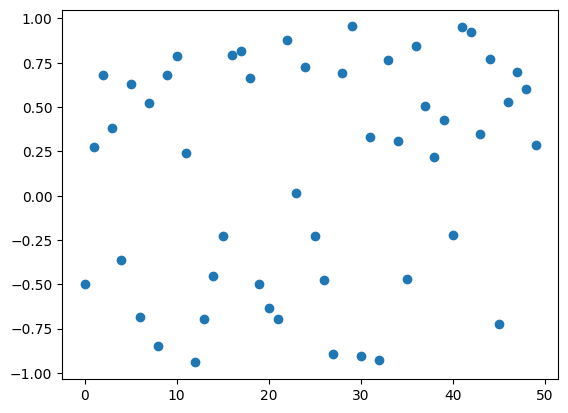

In [4]:
import matplotlib.pyplot as plt
import random

W_realisations = [F_inverse(kappa, random.random()) for xi in range(50)]

plt.scatter(y = W_realisations, x = [x for x in range(len(W_realisations))])
plt.show()

In [5]:
# Sample uniformly a random V on the unit circle
angle = random.uniform(0, 2*pi)
v = S1(angle)
V = [v.z.r, v.z.i]
V

[0.6750187180423527, 0.7378006033424335]

In [21]:
from scipy.spatial.transform import Rotation as R
r90y = R.from_euler('y', -90, degrees=True).as_matrix()
r60y45x = R.from_euler('yx', [60, 45], degrees=True).as_matrix()
r135y =  R.from_euler('y', 135, degrees=True).as_matrix()


def compute_omega(V, W):
    x, y = V
    
    fact = sqrt(1-W**2)
    return [fact * x, fact * y, W]

def vMF(mu, kappa):
    angle = random.uniform(0, 2*pi)
    v = S1(angle)
    V = [v.z.r, v.z.i]
    W = F_inverse(kappa, random.random())
    omega = compute_omega(V, W)
    return omega @ mu


kappa = 50
omegas1 = []
omegas2 = []
omegas3 = []

for _ in range(220):
    omegas1.append(vMF(r90y, 150))
    omegas2.append(vMF(r60y45x, 40))
    omegas3.append(vMF(r135y, 10))


    

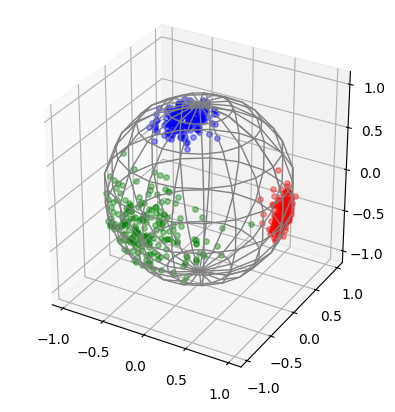

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from itertools import product, combinations


fig = plt.figure()
ax = fig.add_subplot(projection='3d')
#ax.set_aspect("equal")



# draw sphere
u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
x = np.cos(u)*np.sin(v)
y = np.sin(u)*np.sin(v)
z = np.cos(v)
ax.set_box_aspect((np.ptp(x), np.ptp(y), np.ptp(z)))
ax.plot_wireframe(x, y, z, linewidth = 1, color="grey")

# draw a point
for omega in omegas1:
    x, y, z = omega
    ax.scatter(x, y, z, color="r", s=10, alpha = 0.4)
    
for omega in omegas2:
    x, y, z = omega
    ax.scatter(x, y, z, color="b", s=10, alpha = 0.4)
    
for omega in omegas3:
    x, y, z = omega
    ax.scatter(x, y, z, color="g", s=10, alpha = 0.4)


plt.show()